In [1]:
import tensorflow as tf 
import numpy as np 
from tensorflow import keras 
import os 
import math 
import random 
import pickle 
import glob
import matplotlib.pyplot as plt 
from collections import deque 
from tensorflow.keras import layers
import time 
import scipy.io as sio

from vehicle_model_variant import Environment 
from cell_model import CellModel 
from driver_MDP import Driver_MDP 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
drving_cycle = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'
battery_path = "../../OC_SIM_DB/OC_SIM_DB_Bat/OC_SIM_DB_Bat_nimh_6_240_panasonic_MY01_Prius.mat"
motor_path = "../../OC_SIM_DB/OC_SIM_DB_Mot/OC_SIM_DB_Mot_pm_95_145_X2.mat"
cell_model = CellModel()
# env = Environment(cell_model, drving_cycle, battery_path, motor_path, 10)
driver = Driver_MDP(0.02)

num_states = 4

In [3]:
class OUActionNoise: 
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None): 
        self.theta = theta 
        self.mean = mean 
        self.std_dev = std_deviation 
        self.dt = dt 
        self.x_initial = x_initial 
        self.reset() 
        
    def reset(self): 
        if self.x_initial is not None: 
            self.x_prev = self.x_initial 
        else: 
            self.x_prev = 0 
            
    def __call__(self): 
        x = (
             self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt 
            + self.std_dev * np.sqrt(self.dt) * np.random.normal() 
        )
        self.x_prev = x 
        return x 

In [4]:
class Buffer: 
    def __init__(self, buffer_capacity=100000, batch_size=64):      
        self.buffer_capacity = buffer_capacity 
        self.batch_size = batch_size 
        self.buffer_counter = 0 
        
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, 1))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity 

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        
        self.buffer_counter += 1 
        
    def learn(self): 
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        
        with tf.GradientTape() as tape: 
            target_actions = target_actor(next_state_batch)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions])
            critic_value = critic_model([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.square(y - critic_value)) 
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables) 
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )
        
        with tf.GradientTape() as tape: 
            actions = actor_model(state_batch)
            critic_value = critic_model([state_batch, actions])
            actor_loss = - tf.math.reduce_mean(critic_value)
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables) 
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        

In [5]:
def update_target(tau): 
    new_weights = [] 
    target_variables = target_critic.weights
    for i, variable in enumerate(critic_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_critic.set_weights(new_weights)
    
    new_weights = [] 
    target_variables = target_actor.weights
    for i, variable in enumerate(actor_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_actor.set_weights(new_weights)
    

In [6]:
def get_actor(): 
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    inputs = layers.Input(shape=(num_states))
    inputs_batchnorm = layers.BatchNormalization()(inputs)
    
    out = layers.Dense(512, activation="relu")(inputs_batchnorm)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="sigmoid", 
                          kernel_initializer=last_init)(out)
    model = tf.keras.Model(inputs, outputs)
    return model

In [7]:
def get_critic(): 
    state_input = layers.Input(shape=(num_states))
    state_input_batchnorm = layers.BatchNormalization()(state_input)
    
    state_out = layers.Dense(16, activation="relu")(state_input_batchnorm)
#     state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="relu")(state_out)
#     state_out = layers.BatchNormalization()(state_out)
    
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(32, activation="relu")(action_input)
#     action_out = layers.BatchNormalization()(action_out)
    
    concat = layers.Concatenate()([state_out, action_out]) 
    
    out = layers.Dense(512, activation="relu")(concat)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)
    
    model = tf.keras.Model([state_input, action_input], outputs)
    return model 
    

In [8]:
def policy(state, noise_object): 
    j_min = state[0][2].numpy()
    j_max = state[0][3].numpy()
    sampled_action = tf.squeeze(actor_model(state)) 
    noise = noise_object()
    sampled_action = sampled_action.numpy() + noise 
    legal_action = sampled_action * j_max 
    legal_action = np.clip(legal_action, j_min, j_max)
#     print(j_min, j_max, legal_action, noise)
    return legal_action 
    

In [9]:
def policy_epsilon_greedy(state, eps): 
    j_min = state[0][-2].numpy()
    j_max = state[0][-1].numpy()

    if random.random() < eps: 
        a = random.randint(0, 9)
        return np.linspace(j_min, j_max, 10)[a]
    else: 
        sampled_action = tf.squeeze(actor_model(state)).numpy()  
        legal_action = sampled_action * j_max 
        legal_action = np.clip(legal_action, j_min, j_max)
        return legal_action

In [10]:
std_dev = 0.2 
ou_noise = OUActionNoise(mean=0, std_deviation=0.2)

critic_lr = 0.0005 
actor_lr = 0.00025 
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 200 
gamma = 0.95 
tau = 0.001 

MAX_EPSILON = 1.0 
MIN_EPSILON = 0.01 
DECAY_RATE = 0.00002
BATCH_SIZE = 32 
DELAY_TRAINING = 3000 

In [11]:
def initialization(): 
    actor_model = get_actor() 
    critic_model = get_critic() 
    target_actor = get_actor() 
    target_critic = get_critic() 
    target_actor.set_weights(actor_model.get_weights())
    target_critic.set_weights(critic_model.get_weights())
#     actor_model.load_weights("./DDPG1_trial1/actor_model_checkpoint")
#     critic_model.load_weights("./DDPG1_trial1/critic_model_checkpoint")
#     target_actor.load_weights("./DDPG1_trial1/target_actor_checkpoint")
#     target_critic.load_weights("./DDPG1_trial1/target_critic_checkpoint")
    
    buffer = Buffer(500000, BATCH_SIZE)
    return actor_model, critic_model, target_actor, target_critic, buffer

In [12]:
def save_weights(actor_model, critic_model, target_actor, target_critic, root): 
    if not os.path.exists(root): 
        os.makedirs(root)
        
    actor_model.save_weights("./{}/actor_model.h5".format(root))
    critic_model.save_weights("./{}/critic_model.h5".format(root))
    target_actor.save_weights("./{}/target_actor.h5".format(root))
    target_critic.save_weights("./{}/target_critic.h5".format(root))
    print("model is saved..")

In [13]:
def initialization_env(driving_path, reward_factor):
    env = Environment(cell_model, driving_path, battery_path, motor_path, reward_factor)
    return env 

In [14]:
def test_agent(actor_model, reward_factor):
    test_cycle = driver.get_cycle() 
    env = initialization_env(test_cycle, reward_factor)
    
    total_reward = 0
    state = env.reset() 
    while True: 
        tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = policy_epsilon_greedy(tf_state, -1)
        next_state, reward, done = env.step(action)
        
        state = next_state 
        total_reward += reward 
        
        if done: 
            break 
        
    SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
    
    print("******************* Test is start *****************")
#     print(test_cycle)
    print('Total reward: {}'.format(total_reward), 
          "SOC: {:.4f}".format(env.SOC), 
          "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
          "Fuel Consumption: {:.4f}".format(env.fuel_consumption))
    print("******************* Test is done *****************")
    print("")
    plt.subplot(1, 2, 1)
    plt.plot(test_cycle)
    plt.subplot(1, 2, 2)
    plt.plot(env.history["Action"])
    plt.show() 
    return env.history  
    


Trial 0

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 9.710
Episode: 1 Exploration P: 1.0000 Total reward: -5112.7062171133475 SOC: 1.0000 Cumulative_SOC_deviation: 496.1658 Fuel Consumption: 151.0484

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 10.009
Episode: 2 Exploration P: 1.0000 Total reward: -5042.688342821684 SOC: 1.0000 Cumulative_SOC_deviation: 488.7802 Fuel Consumption: 154.8867

../data/driving_cycles/city\01_FTP72_fuds.mat

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autoc

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -685.1164012994647 SOC: 0.4160 Cumulative_SOC_deviation: 68.3808 Fuel Consumption: 1.3085
******************* Test is done *****************



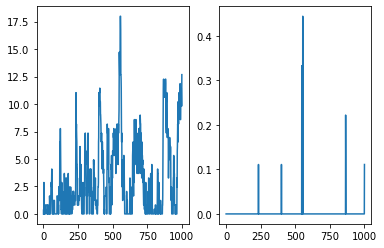

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 81.146
Episode: 11 Exploration P: 0.7872 Total reward: -4760.005233581113 SOC: 1.0000 Cumulative_SOC_deviation: 463.3813 Fuel Consumption: 126.1920

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 83.058
Episode: 12 Exploration P: 0.7661 Total reward: -4777.329100449754 SOC: 1.0000 Cumulative_SOC_deviation: 465.0219 Fuel Consumption: 127.1103

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 83.164
Episode: 13 Exploration P: 0.7456 Total reward: -4735.6056491657455 SOC: 1.0000 Cumulative_SOC_deviation: 461.4645 Fuel Consumption: 120.9607

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 81.607
Episode: 14 Exploration P: 0.7257 Total reward: -4686.106302089907 SOC: 1.0000 Cumulative_SOC_deviation: 456.8303 Fuel Consumption: 117.8033

../data

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


battery power is 104576.44360479918(+) but condition is not avail
******************* Test is start *****************
Total reward: -1251.4206902460767 SOC: 0.2915 Cumulative_SOC_deviation: 24.2989 Fuel Consumption: 11.5165
******************* Test is done *****************



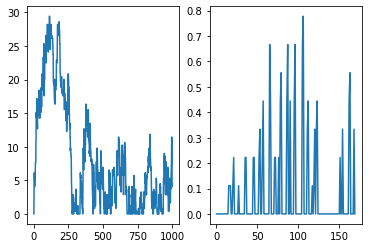

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 80.791
Episode: 21 Exploration P: 0.6006 Total reward: -4229.257927118587 SOC: 1.0000 Cumulative_SOC_deviation: 412.5745 Fuel Consumption: 103.5127

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 79.400
Episode: 22 Exploration P: 0.5846 Total reward: -4234.222875352915 SOC: 1.0000 Cumulative_SOC_deviation: 413.2485 Fuel Consumption: 101.7380

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 79.832
Episode: 23 Exploration P: 0.5690 Total reward: -3797.7235657650563 SOC: 1.0000 Cumulative_SOC_deviation: 369.8421 Fuel Consumption: 99.3029

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 78.907
Episode: 24 Exploration P: 0.5539 Total reward: -4029.2833080902687 SOC: 1.0000 Cumulative_SOC_deviation: 392.9743 Fuel Consumption: 99.5402

../data/

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -748.2742344768544 SOC: 0.3862 Cumulative_SOC_deviation: 74.6966 Fuel Consumption: 1.3085
******************* Test is done *****************



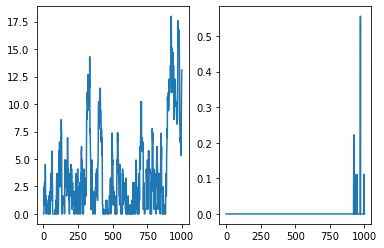

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 114.813
Episode: 31 Exploration P: 0.4587 Total reward: -3066.6632071332406 SOC: 1.0000 Cumulative_SOC_deviation: 297.8060 Fuel Consumption: 88.6030

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 118.585
Episode: 32 Exploration P: 0.4466 Total reward: -2980.3013468654044 SOC: 1.0000 Cumulative_SOC_deviation: 289.0470 Fuel Consumption: 89.8309

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 115.778
Episode: 33 Exploration P: 0.4348 Total reward: -2972.395582682375 SOC: 1.0000 Cumulative_SOC_deviation: 288.4133 Fuel Consumption: 88.2625

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 115.573
Episode: 34 Exploration P: 0.4233 Total reward: -2317.469410242624 SOC: 1.0000 Cumulative_SOC_deviation: 223.2302 Fuel Consumption: 85.1671

../dat

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -2309.006144517848 SOC: 0.1774 Cumulative_SOC_deviation: 229.6368 Fuel Consumption: 12.6378
******************* Test is done *****************



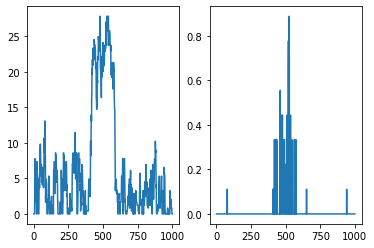

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 85.000
Episode: 41 Exploration P: 0.3510 Total reward: -2045.8464191721905 SOC: 0.9683 Cumulative_SOC_deviation: 196.4373 Fuel Consumption: 81.4732

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 85.139
Episode: 42 Exploration P: 0.3418 Total reward: -770.0183098546368 SOC: 0.7613 Cumulative_SOC_deviation: 70.3837 Fuel Consumption: 66.1817

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 84.929
Episode: 43 Exploration P: 0.3328 Total reward: -1390.99753255812 SOC: 0.8680 Cumulative_SOC_deviation: 131.7129 Fuel Consumption: 73.8687

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 84.509
Episode: 44 Exploration P: 0.3240 Total reward: -1094.2230702686024 SOC: 0.8241 Cumulative_SOC_deviation: 102.3109 Fuel Consumption: 71.1138

../data/driv

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -897.9159210990076 SOC: 0.3901 Cumulative_SOC_deviation: 89.5679 Fuel Consumption: 2.2371
******************* Test is done *****************



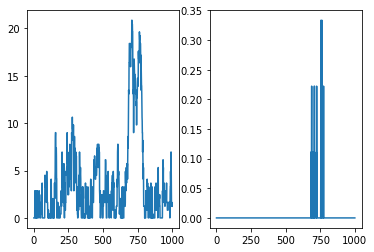

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 110.877
Episode: 51 Exploration P: 0.2691 Total reward: -793.824260609198 SOC: 0.7131 Cumulative_SOC_deviation: 73.0542 Fuel Consumption: 63.2823

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 113.323
Episode: 52 Exploration P: 0.2621 Total reward: -639.8956190795659 SOC: 0.6787 Cumulative_SOC_deviation: 58.0266 Fuel Consumption: 59.6297

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 112.537
Episode: 53 Exploration P: 0.2553 Total reward: -882.6211661703123 SOC: 0.6419 Cumulative_SOC_deviation: 82.4921 Fuel Consumption: 57.7002

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 114.089
Episode: 54 Exploration P: 0.2486 Total reward: -644.1959215595903 SOC: 0.6999 Cumulative_SOC_deviation: 58.2595 Fuel Consumption: 61.6004

../data/drivi

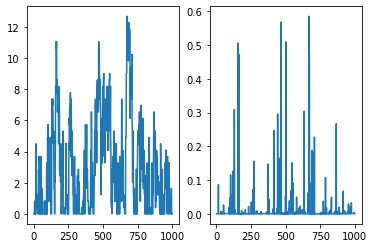

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 83.126
Episode: 61 Exploration P: 0.2069 Total reward: -306.1874831305671 SOC: 0.6514 Cumulative_SOC_deviation: 25.0948 Fuel Consumption: 55.2398

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 83.917
Episode: 62 Exploration P: 0.2016 Total reward: -595.2821115855199 SOC: 0.7312 Cumulative_SOC_deviation: 53.3539 Fuel Consumption: 61.7432

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 82.898
Episode: 63 Exploration P: 0.1964 Total reward: -375.3483926128582 SOC: 0.6803 Cumulative_SOC_deviation: 31.7907 Fuel Consumption: 57.4413

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 81.277
Episode: 64 Exploration P: 0.1913 Total reward: -219.62187658851684 SOC: 0.6348 Cumulative_SOC_deviation: 16.5765 Fuel Consumption: 53.8572

../data/driving

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -109.17171099334293 SOC: 0.5946 Cumulative_SOC_deviation: 9.3877 Fuel Consumption: 15.2950
******************* Test is done *****************



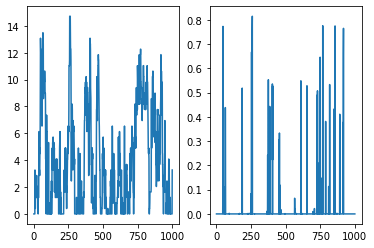

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 83.008
Episode: 71 Exploration P: 0.1596 Total reward: -164.01730074010482 SOC: 0.6060 Cumulative_SOC_deviation: 11.1746 Fuel Consumption: 52.2717

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 82.930
Episode: 72 Exploration P: 0.1556 Total reward: -164.77229850821652 SOC: 0.6276 Cumulative_SOC_deviation: 11.2079 Fuel Consumption: 52.6932

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 83.022
Episode: 73 Exploration P: 0.1516 Total reward: -215.5361283155462 SOC: 0.6429 Cumulative_SOC_deviation: 16.1240 Fuel Consumption: 54.2959

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 82.827
Episode: 74 Exploration P: 0.1478 Total reward: -185.15224215832885 SOC: 0.6329 Cumulative_SOC_deviation: 13.2007 Fuel Consumption: 53.1452

../data/drivi

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -40.43543926088055 SOC: 0.5959 Cumulative_SOC_deviation: 3.2488 Fuel Consumption: 7.9479
******************* Test is done *****************



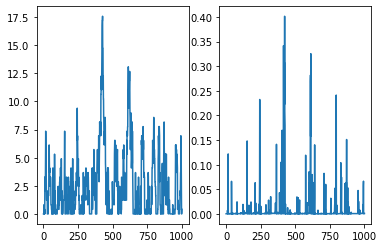

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 94.851
Episode: 81 Exploration P: 0.1237 Total reward: -129.99372755979164 SOC: 0.6076 Cumulative_SOC_deviation: 8.1158 Fuel Consumption: 48.8360

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 127.199
Episode: 82 Exploration P: 0.1206 Total reward: -154.58716619343852 SOC: 0.6142 Cumulative_SOC_deviation: 10.4959 Fuel Consumption: 49.6284

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 134.939
Episode: 83 Exploration P: 0.1176 Total reward: -124.85265059019734 SOC: 0.6150 Cumulative_SOC_deviation: 7.5605 Fuel Consumption: 49.2472

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 135.547
Episode: 84 Exploration P: 0.1147 Total reward: -148.66393542398535 SOC: 0.6044 Cumulative_SOC_deviation: 9.8983 Fuel Consumption: 49.6804

../data/driv

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -74.39864913829373 SOC: 0.5988 Cumulative_SOC_deviation: 3.2146 Fuel Consumption: 42.2523
******************* Test is done *****************



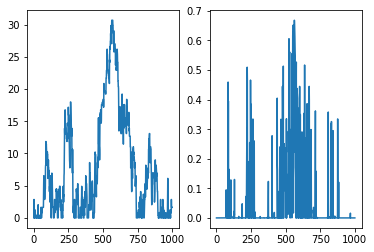

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 85.828
Episode: 91 Exploration P: 0.0964 Total reward: -119.99746560758804 SOC: 0.6079 Cumulative_SOC_deviation: 7.1552 Fuel Consumption: 48.4451

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 84.885
Episode: 92 Exploration P: 0.0940 Total reward: -134.06548728871465 SOC: 0.6023 Cumulative_SOC_deviation: 8.5756 Fuel Consumption: 48.3094

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 84.658
Episode: 93 Exploration P: 0.0918 Total reward: -132.69685666696827 SOC: 0.6023 Cumulative_SOC_deviation: 8.4424 Fuel Consumption: 48.2728

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 79.582
Episode: 94 Exploration P: 0.0896 Total reward: -132.28572277803906 SOC: 0.6050 Cumulative_SOC_deviation: 8.4223 Fuel Consumption: 48.0625

../data/driving_

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -60.78298994299475 SOC: 0.5928 Cumulative_SOC_deviation: 4.6852 Fuel Consumption: 13.9314
******************* Test is done *****************



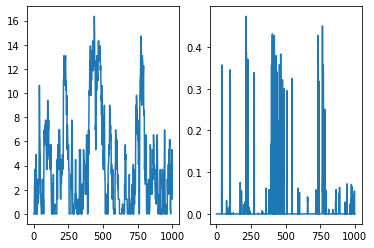

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 80.805
Episode: 101 Exploration P: 0.0756 Total reward: -131.11859550486392 SOC: 0.6030 Cumulative_SOC_deviation: 8.2914 Fuel Consumption: 48.2051

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 80.514
Episode: 102 Exploration P: 0.0739 Total reward: -142.31954665359936 SOC: 0.5985 Cumulative_SOC_deviation: 9.5457 Fuel Consumption: 46.8628

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 80.774
Episode: 103 Exploration P: 0.0721 Total reward: -151.82271812751307 SOC: 0.6007 Cumulative_SOC_deviation: 10.4578 Fuel Consumption: 47.2447

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 80.428
Episode: 104 Exploration P: 0.0705 Total reward: -147.8845675440762 SOC: 0.5937 Cumulative_SOC_deviation: 10.0837 Fuel Consumption: 47.0479

../data/dri

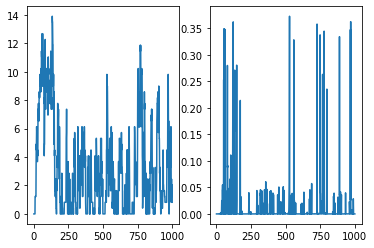

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 80.355
Episode: 111 Exploration P: 0.0599 Total reward: -147.5664660319355 SOC: 0.6034 Cumulative_SOC_deviation: 9.9858 Fuel Consumption: 47.7082

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 80.516
Episode: 112 Exploration P: 0.0585 Total reward: -143.3346632697453 SOC: 0.5983 Cumulative_SOC_deviation: 9.5949 Fuel Consumption: 47.3862

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 80.381
Episode: 113 Exploration P: 0.0572 Total reward: -146.20796699136673 SOC: 0.6038 Cumulative_SOC_deviation: 9.8001 Fuel Consumption: 48.2071

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 80.459
Episode: 114 Exploration P: 0.0559 Total reward: -177.00358133634944 SOC: 0.5984 Cumulative_SOC_deviation: 12.9202 Fuel Consumption: 47.8015

../data/drivi

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -83.62601340256577 SOC: 0.5950 Cumulative_SOC_deviation: 5.0301 Fuel Consumption: 33.3254
******************* Test is done *****************



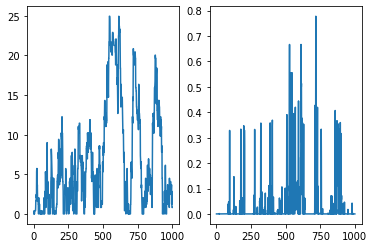

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 80.975
Episode: 121 Exploration P: 0.0479 Total reward: -129.27337781053808 SOC: 0.6031 Cumulative_SOC_deviation: 8.2210 Fuel Consumption: 47.0635

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 80.389
Episode: 122 Exploration P: 0.0469 Total reward: -185.2372811767832 SOC: 0.5924 Cumulative_SOC_deviation: 13.8969 Fuel Consumption: 46.2678

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 79.712
Episode: 123 Exploration P: 0.0459 Total reward: -204.49114585863242 SOC: 0.5914 Cumulative_SOC_deviation: 15.8496 Fuel Consumption: 45.9950

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 81.328
Episode: 124 Exploration P: 0.0449 Total reward: -190.95306879621876 SOC: 0.5952 Cumulative_SOC_deviation: 14.4768 Fuel Consumption: 46.1851

../data/dr

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -71.39036128242314 SOC: 0.5927 Cumulative_SOC_deviation: 6.1253 Fuel Consumption: 10.1370
******************* Test is done *****************



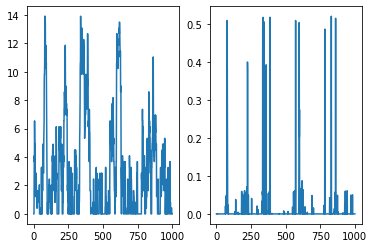

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 80.100
Episode: 131 Exploration P: 0.0388 Total reward: -190.7644404262669 SOC: 0.5960 Cumulative_SOC_deviation: 14.3687 Fuel Consumption: 47.0778

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 78.324
Episode: 132 Exploration P: 0.0380 Total reward: -146.69647146003146 SOC: 0.6006 Cumulative_SOC_deviation: 9.8958 Fuel Consumption: 47.7383

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 80.058
Episode: 133 Exploration P: 0.0373 Total reward: -145.5358984435525 SOC: 0.5974 Cumulative_SOC_deviation: 9.8173 Fuel Consumption: 47.3628

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 79.800
Episode: 134 Exploration P: 0.0365 Total reward: -139.19215893231518 SOC: 0.5964 Cumulative_SOC_deviation: 9.1539 Fuel Consumption: 47.6536

../data/drivi

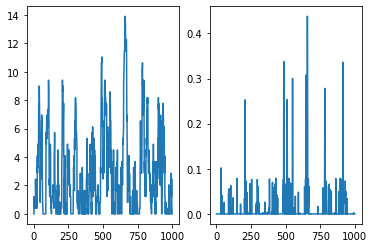

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 128.297
Episode: 141 Exploration P: 0.0319 Total reward: -189.1294804219009 SOC: 0.5941 Cumulative_SOC_deviation: 14.3012 Fuel Consumption: 46.1171

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 128.134
Episode: 142 Exploration P: 0.0313 Total reward: -240.7399537630259 SOC: 0.5912 Cumulative_SOC_deviation: 19.4794 Fuel Consumption: 45.9463

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 131.667
Episode: 143 Exploration P: 0.0307 Total reward: -176.20716497966148 SOC: 0.5984 Cumulative_SOC_deviation: 12.9019 Fuel Consumption: 47.1885

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 122.517
Episode: 144 Exploration P: 0.0302 Total reward: -156.62705038544078 SOC: 0.6008 Cumulative_SOC_deviation: 10.9458 Fuel Consumption: 47.1689

../dat

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -74.5539442089819 SOC: 0.5933 Cumulative_SOC_deviation: 6.5839 Fuel Consumption: 8.7148
******************* Test is done *****************



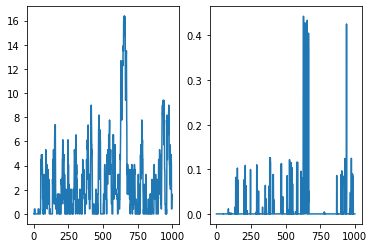

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 83.800
Episode: 151 Exploration P: 0.0266 Total reward: -244.82403587361688 SOC: 0.5935 Cumulative_SOC_deviation: 19.7969 Fuel Consumption: 46.8549

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 86.128
Episode: 152 Exploration P: 0.0262 Total reward: -151.63953852358156 SOC: 0.5966 Cumulative_SOC_deviation: 10.4710 Fuel Consumption: 46.9300

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 81.059
Episode: 153 Exploration P: 0.0257 Total reward: -172.97115633175656 SOC: 0.5963 Cumulative_SOC_deviation: 12.6256 Fuel Consumption: 46.7148

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 80.513
Episode: 154 Exploration P: 0.0253 Total reward: -171.2135676123841 SOC: 0.5963 Cumulative_SOC_deviation: 12.3828 Fuel Consumption: 47.3859

../data/d

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -49.92771513808161 SOC: 0.5968 Cumulative_SOC_deviation: 4.1678 Fuel Consumption: 8.2500
******************* Test is done *****************



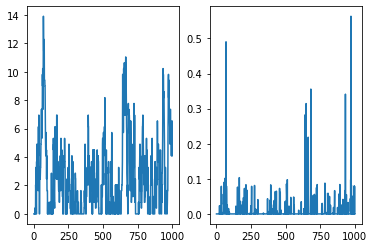

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 108.378
Episode: 161 Exploration P: 0.0226 Total reward: -145.58424509589847 SOC: 0.5998 Cumulative_SOC_deviation: 9.8536 Fuel Consumption: 47.0487

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 108.296
Episode: 162 Exploration P: 0.0223 Total reward: -130.62545396632666 SOC: 0.5954 Cumulative_SOC_deviation: 8.4135 Fuel Consumption: 46.4908

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 108.074
Episode: 163 Exploration P: 0.0220 Total reward: -150.6932232989184 SOC: 0.5993 Cumulative_SOC_deviation: 10.3372 Fuel Consumption: 47.3210

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 108.130
Episode: 164 Exploration P: 0.0216 Total reward: -139.12758955170585 SOC: 0.5990 Cumulative_SOC_deviation: 9.1977 Fuel Consumption: 47.1505

../data/

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -114.66185536080846 SOC: 0.5939 Cumulative_SOC_deviation: 8.2674 Fuel Consumption: 31.9878
******************* Test is done *****************



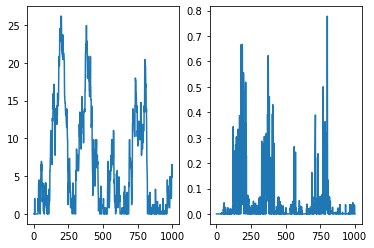

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 80.692
Episode: 171 Exploration P: 0.0196 Total reward: -154.0279198381455 SOC: 0.5965 Cumulative_SOC_deviation: 10.7307 Fuel Consumption: 46.7205

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 81.763
Episode: 172 Exploration P: 0.0193 Total reward: -147.79208598394035 SOC: 0.6005 Cumulative_SOC_deviation: 10.1013 Fuel Consumption: 46.7794

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 81.879
Episode: 173 Exploration P: 0.0191 Total reward: -134.36937491793188 SOC: 0.5995 Cumulative_SOC_deviation: 8.7549 Fuel Consumption: 46.8204

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 88.796
Episode: 174 Exploration P: 0.0188 Total reward: -148.28397794678187 SOC: 0.5982 Cumulative_SOC_deviation: 10.1128 Fuel Consumption: 47.1557

../data/dr

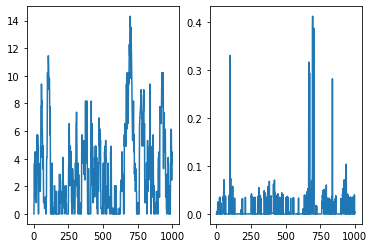

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 81.534
Episode: 181 Exploration P: 0.0173 Total reward: -138.43637062590457 SOC: 0.5991 Cumulative_SOC_deviation: 9.1630 Fuel Consumption: 46.8059

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 81.776
Episode: 182 Exploration P: 0.0171 Total reward: -153.50074772587433 SOC: 0.6001 Cumulative_SOC_deviation: 10.6828 Fuel Consumption: 46.6724

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 81.047
Episode: 183 Exploration P: 0.0169 Total reward: -144.6772160560879 SOC: 0.5979 Cumulative_SOC_deviation: 9.7493 Fuel Consumption: 47.1841

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 80.556
Episode: 184 Exploration P: 0.0167 Total reward: -142.4757456108293 SOC: 0.5946 Cumulative_SOC_deviation: 9.5531 Fuel Consumption: 46.9447

../data/drivi

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -62.32600674940553 SOC: 0.6018 Cumulative_SOC_deviation: 3.6971 Fuel Consumption: 25.3549
******************* Test is done *****************



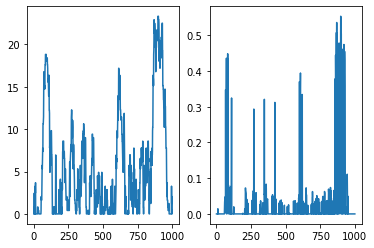

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 74.802
Episode: 191 Exploration P: 0.0155 Total reward: -134.42984158811953 SOC: 0.6023 Cumulative_SOC_deviation: 8.7294 Fuel Consumption: 47.1360

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 74.445
Episode: 192 Exploration P: 0.0154 Total reward: -138.58905925402496 SOC: 0.5980 Cumulative_SOC_deviation: 9.1472 Fuel Consumption: 47.1174

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 75.162
Episode: 193 Exploration P: 0.0152 Total reward: -134.14122165386485 SOC: 0.5993 Cumulative_SOC_deviation: 8.6544 Fuel Consumption: 47.5971

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 73.963
Episode: 194 Exploration P: 0.0151 Total reward: -127.22811815676923 SOC: 0.5986 Cumulative_SOC_deviation: 7.8855 Fuel Consumption: 48.3734

../data/driv

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -43.325949167626305 SOC: 0.5988 Cumulative_SOC_deviation: 3.4467 Fuel Consumption: 8.8593
******************* Test is done *****************



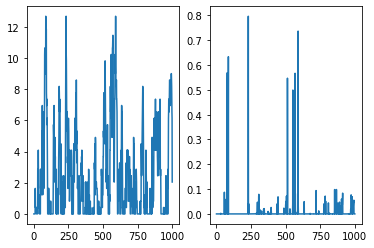

model is saved..


In [15]:
# print(env.version)

num_trials = 1
results_dict = {} 
driving_cycle_paths = glob.glob("../data/driving_cycles/city/*.mat")[:1]

for trial in range(num_trials): 
    print("")
    print("Trial {}".format(trial))
    print("")
    
    actor_model, critic_model, target_actor, target_critic, buffer = initialization()
    
    eps = MAX_EPSILON 
    steps = 0
    
    episode_rewards = [] 
    episode_SOCs = [] 
    episode_FCs = [] 
    episode_test_history = [] 
    episode_num_test = [] 
    for ep in range(total_episodes):
        i = ep % len(driving_cycle_paths)
        driving_cycle_path =driving_cycle_paths[i]
        print(driving_cycle_path)
        drv_cycle = sio.loadmat(driving_cycle_path)
        driving_cycle = drv_cycle["sch_cycle"][:, 1]

        env = initialization_env(driving_cycle, 10)
        
        start = time.time() 
        state = env.reset() 
        episodic_reward = 0 

        while True: 
            tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
            action = policy_epsilon_greedy(tf_state, eps)
    #         print(action)
            next_state, reward, done = env.step(action)
            if done: 
                next_state = [0] * num_states 

            buffer.record((state, action, reward, next_state))
            episodic_reward += reward 

            if steps > DELAY_TRAINING: 
                buffer.learn() 
                update_target(tau)
                eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY_RATE * (steps
                                                                        -DELAY_TRAINING))

            steps += 1

            if done: 
                break 

            state = next_state 

        elapsed_time = time.time() - start 
        print("elapsed_time: {:.3f}".format(elapsed_time))
        episode_rewards.append(episodic_reward) 
        episode_SOCs.append(env.SOC)
        episode_FCs.append(env.fuel_consumption) 

    #     print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
        SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
        print(
              'Episode: {}'.format(ep + 1),
              "Exploration P: {:.4f}".format(eps),
              'Total reward: {}'.format(episodic_reward), 
              "SOC: {:.4f}".format(env.SOC), 
              "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
              "Fuel Consumption: {:.4f}".format(env.fuel_consumption), 
        )
        print("")
        
        if (ep + 1) % 10 == 0: 
            history = test_agent(actor_model, 10)
            episode_test_history.append(history) 
            episode_num_test.append(ep + 1)
            
    root = "DDPG_reference_trained_one_mass1200"
    save_weights(actor_model, critic_model, target_actor, target_critic, root)
    
    results_dict[trial + 1] = {
        "rewards": episode_rewards, 
        "SOCs": episode_SOCs, 
        "FCs": episode_FCs, 
        "test_history": episode_test_history, 
        "test_episode_num": episode_num_test, 
    }

In [16]:
with open("DDPG_reference_one_mass1200.pkl", "wb") as f: 
    pickle.dump(results_dict, f, pickle.HIGHEST_PROTOCOL)

In [17]:
# results_dict